<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/6.%20parameters_by_period/area_spm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai2')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

12 imagens retiradas por ainda ter muita cobertura de nuvens e muitos 'buracos' por causa disso.

In [43]:
monthly_mosaics =  ee.ImageCollection('projects/ee-curuai2/assets/landsat_water_period/water_period')
display(monthly_mosaics.limit(2).getInfo())

{'type': 'ImageCollection',
 'bands': [],
 'version': 1741027115448792,
 'id': 'projects/ee-curuai2/assets/landsat_water_period/water_period',
 'features': [{'type': 'Image',
   'bands': [{'id': 'blue_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'green_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'red_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'nir_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
 

## Get mean SPM value per image

In [44]:
def spm_stat_calc(img):
  '''receives a masked SPM classified image of curuai and returns mean SPM within the floodplain limits
  as a property of the input image'''


  floodplain = ee.FeatureCollection('projects/ee-curuai2/assets/varzea_alagavel')


  stats = img.select("classification").reduceRegion(**{
    'reducer': ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(), sharedInputs=True).combine(
    reducer2=ee.Reducer.max(), sharedInputs=True).combine(
    reducer2=ee.Reducer.min(), sharedInputs=True),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })

  return img.set({'mean_SPM':stats.get('classification_mean'),
                  'max_SPM':stats.get('classification_max'),
                  'min_SPM':stats.get('classification_min'),
                  'stdDev_SPM':stats.get('classification_stdDev')})

In [45]:
spm_classified_stat = monthly_mosaics.map(spm_stat_calc)
display(spm_classified_stat.size().getInfo())

88

#transform to dataframe

In [46]:
dfArea = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(spm_classified_stat.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})
dfArea

,geo,area_km2,band_count,max_SPM,mean_SPM,min_SPM,month_end,month_init,stdDev_SPM,timestamp,year
0,None,989.084758,6,306.049042,73.535345,6.644032,3,1,51.890127,2000-01-01,2000
1,None,1335.446135,6,282.490112,22.679618,5.844900,9,7,15.929416,2000-07-01,2000
2,None,983.227657,6,306.049042,134.038118,8.780909,12,10,74.673074,2000-10-01,2000
3,None,1134.171724,6,306.049042,93.210925,6.623919,3,1,65.276331,2001-01-01,2001
4,None,1335.085554,6,282.490112,18.724521,5.401382,6,4,15.715166,2001-04-01,2001
...,...,...,...,...,...,...,...,...,...,...,...
83,None,463.786451,6,306.049042,208.968305,6.781344,12,10,61.418259,2023-10-01,2023
84,None,949.024621,6,306.049042,36.722792,5.868872,3,1,20.214386,2024-01-01,2024
85,None,1296.697903,6,282.490112,32.580176,5.754973,6,4,18.713887,2024-04-01,2024
86,None,1268.924408,6,226.239838,39.458892,5.868872,9,7,12.820446,2024-07-01,2024


In [47]:
def return_period(month):
  if month == 1:
    return 'R'
  elif month == 4:
    return 'HW'
  elif month == 7:
    return 'F'
  elif month == 10:
    return 'LW'
  else:
    return 'U'

In [48]:
dfArea = dfArea[['area_km2','mean_SPM','max_SPM','min_SPM','stdDev_SPM',	'month_end',	'month_init',	'timestamp',	'year',]].copy()
dfArea['WATER_PERIOD'] = dfArea.apply(lambda row: return_period(row['month_init']),axis = 1)
dfArea

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,month_end,month_init,timestamp,year,WATER_PERIOD
0,989.084758,73.535345,306.049042,6.644032,51.890127,3,1,2000-01-01,2000,R
1,1335.446135,22.679618,282.490112,5.844900,15.929416,9,7,2000-07-01,2000,F
2,983.227657,134.038118,306.049042,8.780909,74.673074,12,10,2000-10-01,2000,LW
3,1134.171724,93.210925,306.049042,6.623919,65.276331,3,1,2001-01-01,2001,R
4,1335.085554,18.724521,282.490112,5.401382,15.715166,6,4,2001-04-01,2001,HW
...,...,...,...,...,...,...,...,...,...,...
83,463.786451,208.968305,306.049042,6.781344,61.418259,12,10,2023-10-01,2023,LW
84,949.024621,36.722792,306.049042,5.868872,20.214386,3,1,2024-01-01,2024,R
85,1296.697903,32.580176,282.490112,5.754973,18.713887,6,4,2024-04-01,2024,HW
86,1268.924408,39.458892,226.239838,5.868872,12.820446,9,7,2024-07-01,2024,F


#view time series

## area vs time

<Axes: xlabel='timestamp', ylabel='area_km2'>

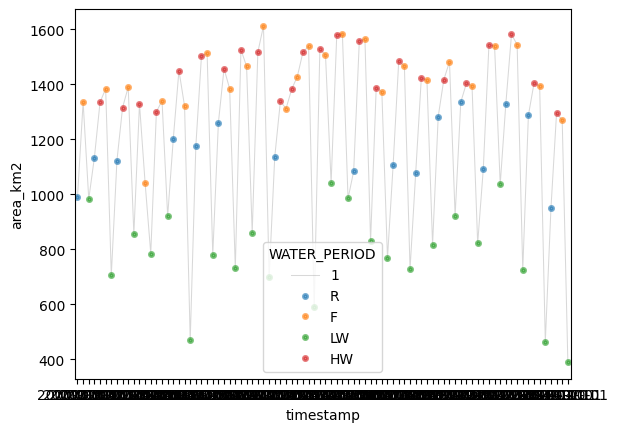

In [49]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

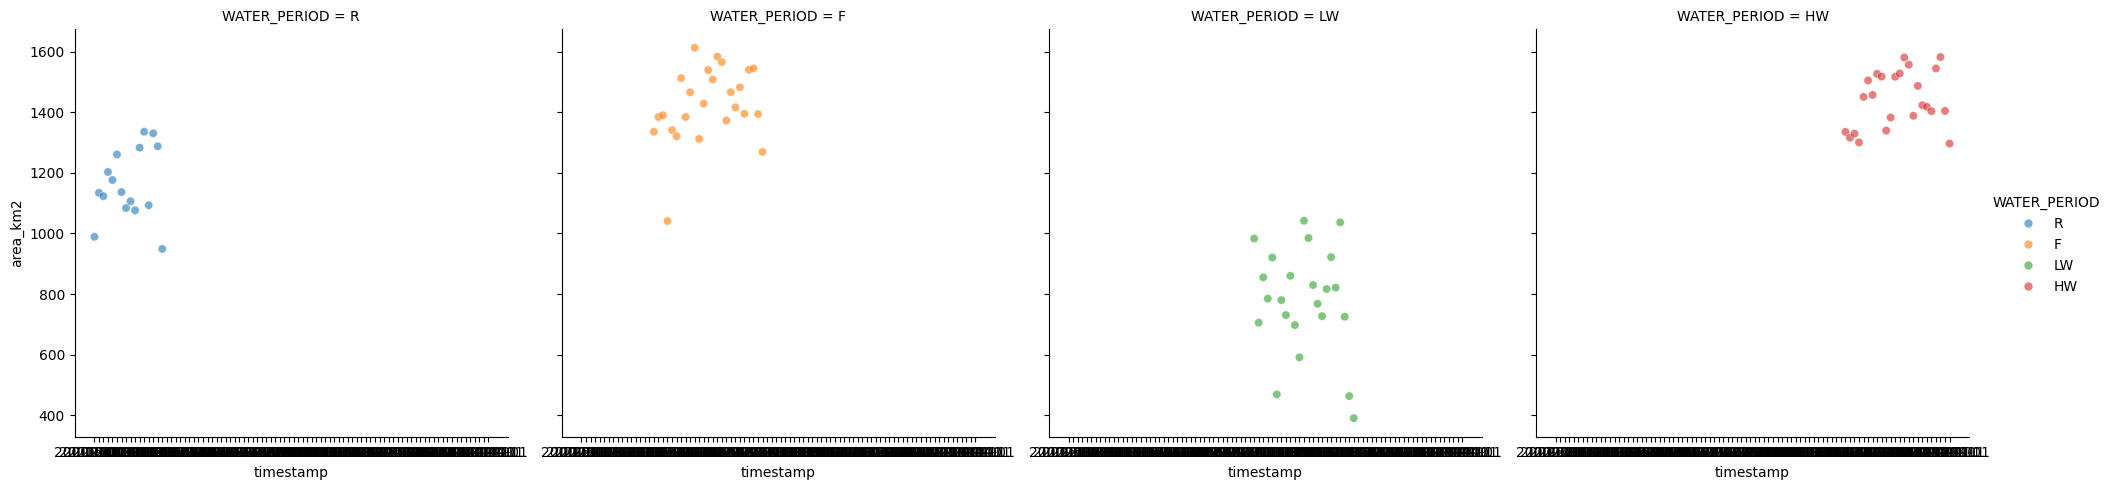

In [50]:

sns.relplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## area vs spm

### mean spm

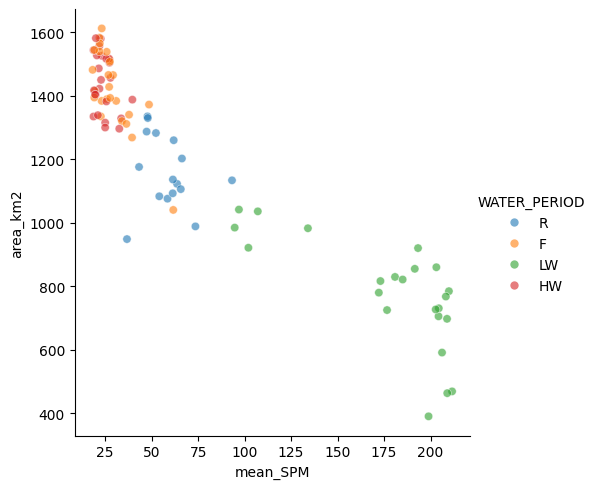

In [51]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

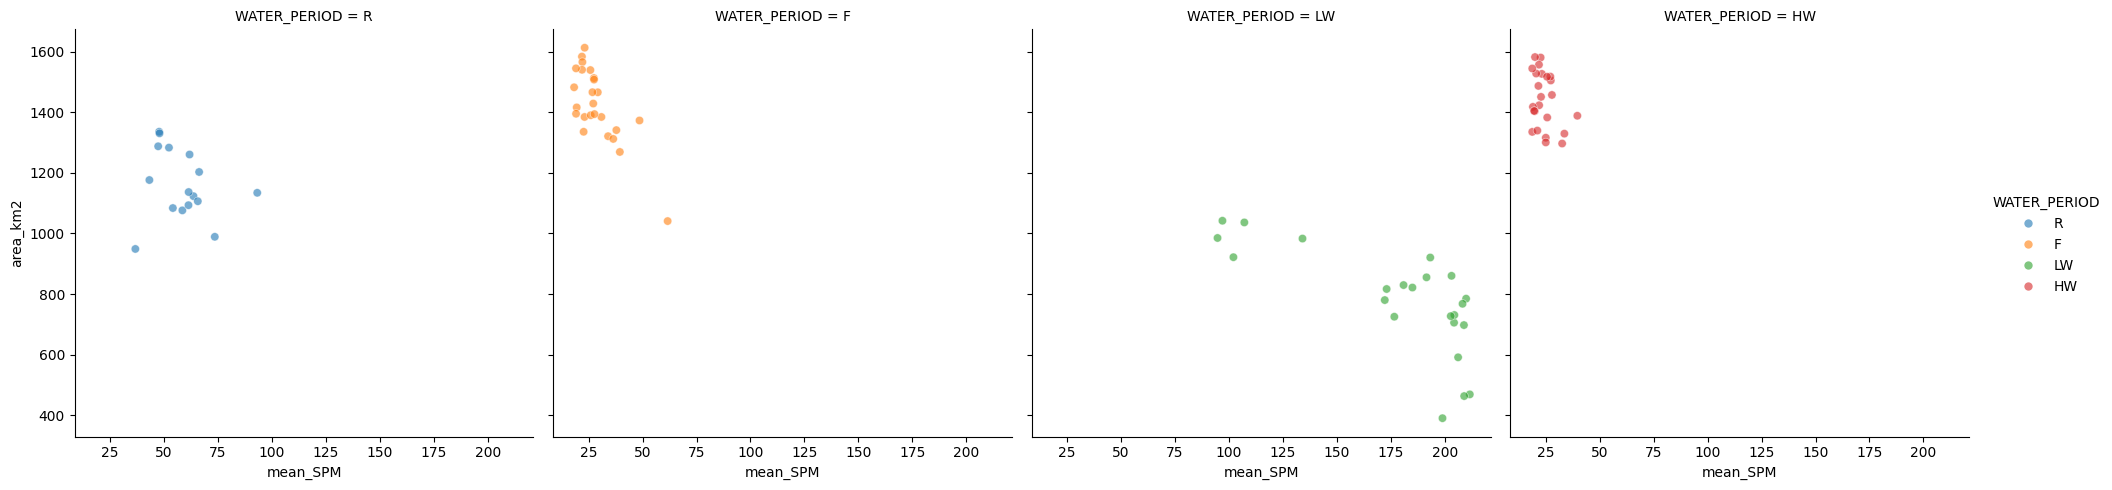

In [52]:
sns.relplot(data=dfArea, x ='mean_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

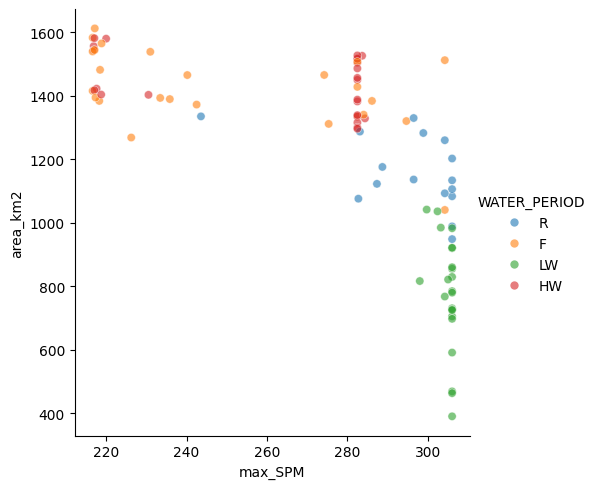

In [53]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

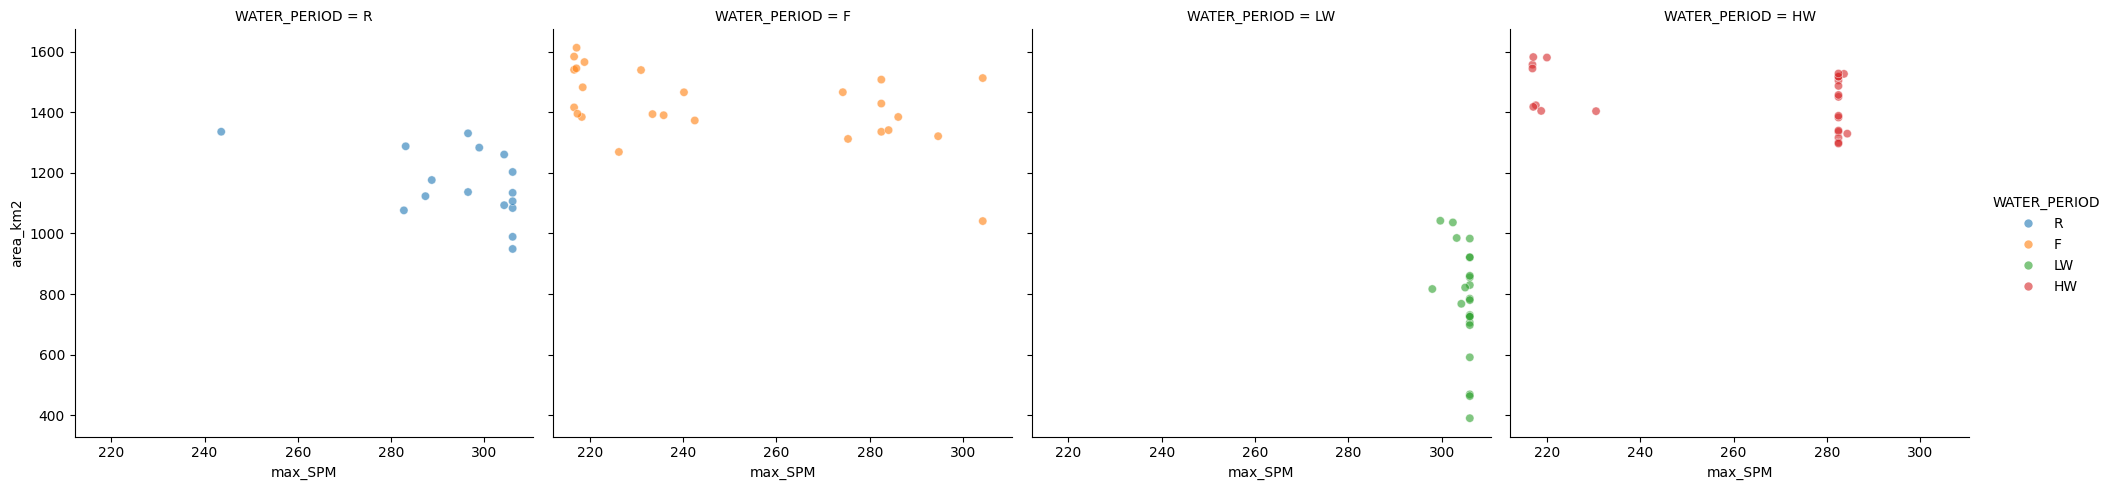

In [54]:
sns.relplot(data=dfArea, x ='max_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

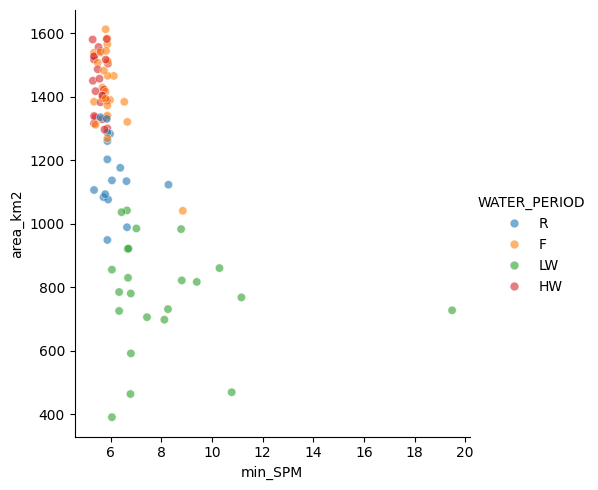

In [55]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

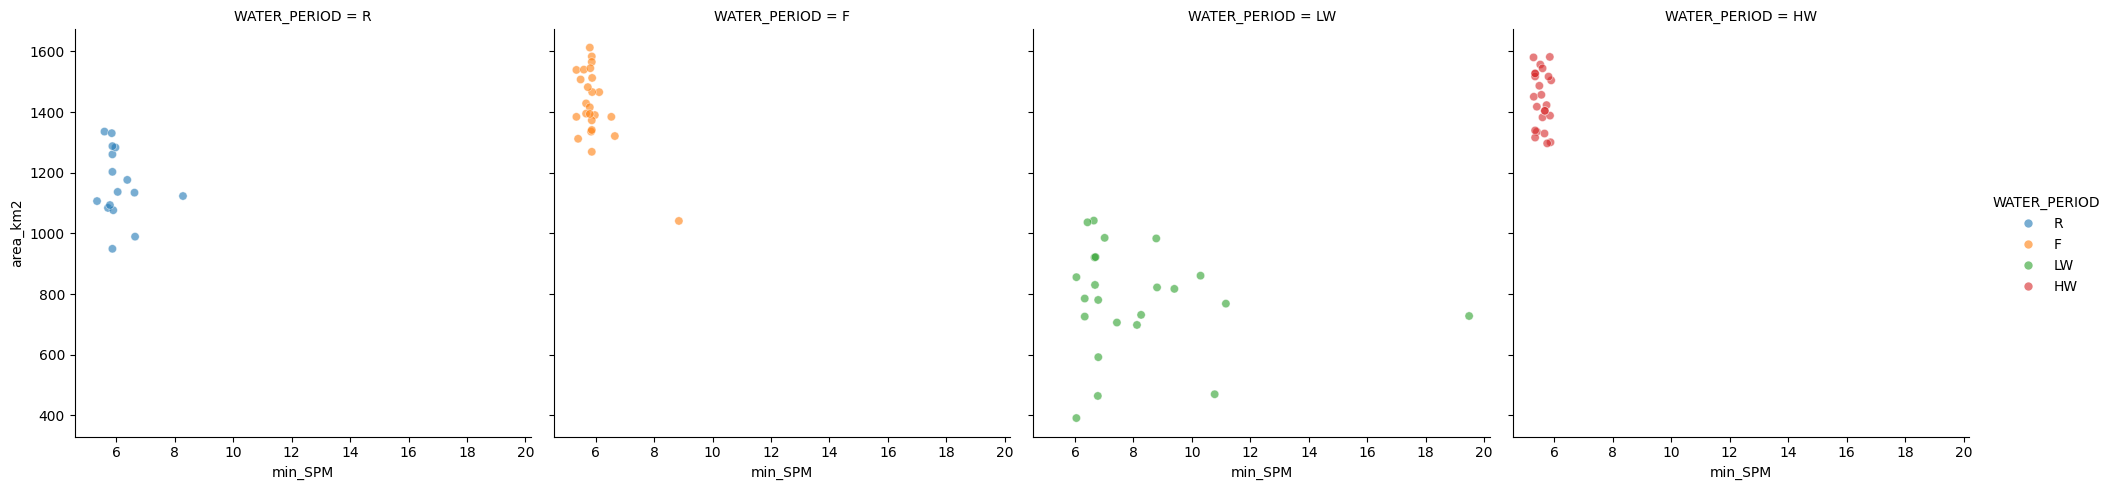

In [56]:
sns.relplot(data=dfArea, x ='min_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

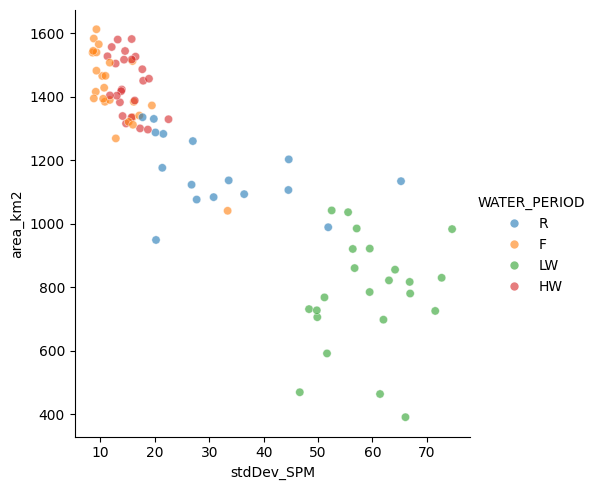

In [57]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD')

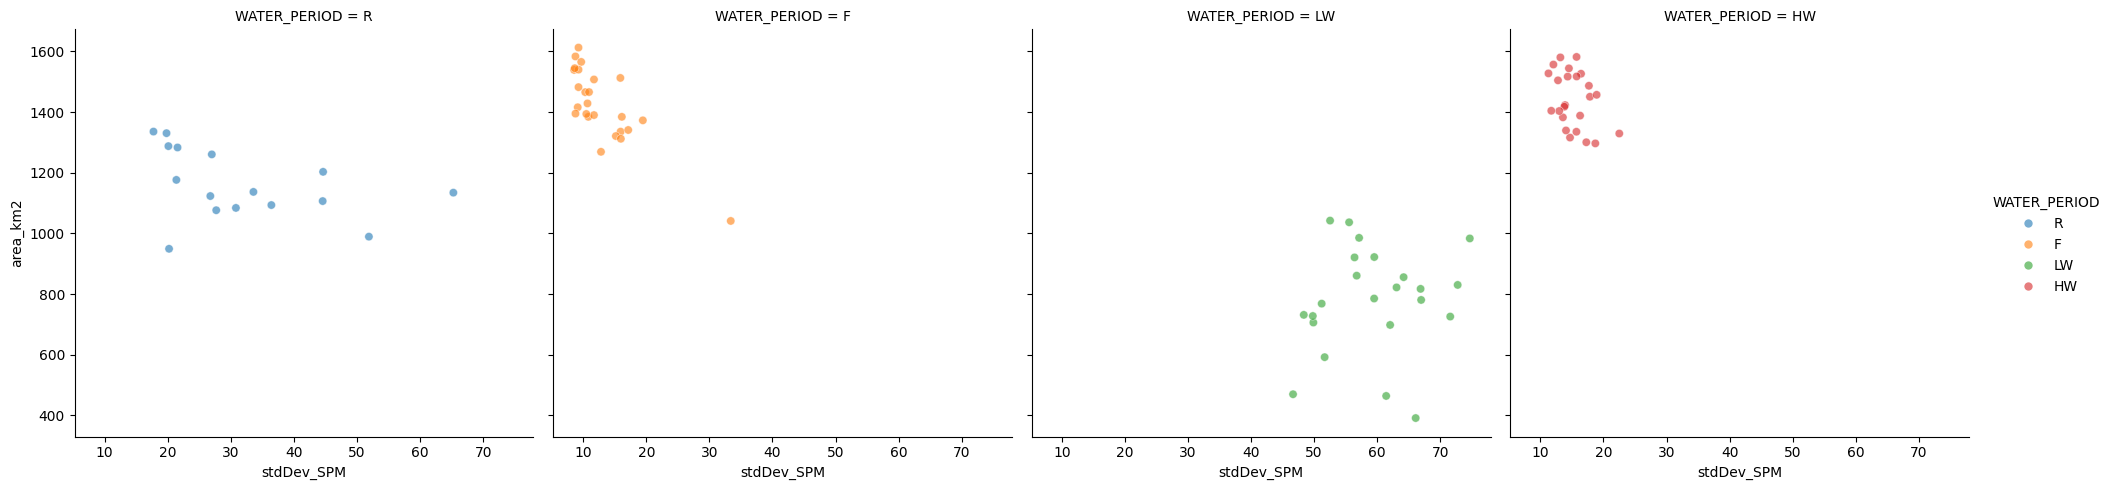

In [58]:
sns.relplot(data=dfArea, x ='stdDev_SPM',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## spm vs time

### mean spm

<Axes: xlabel='timestamp', ylabel='mean_SPM'>

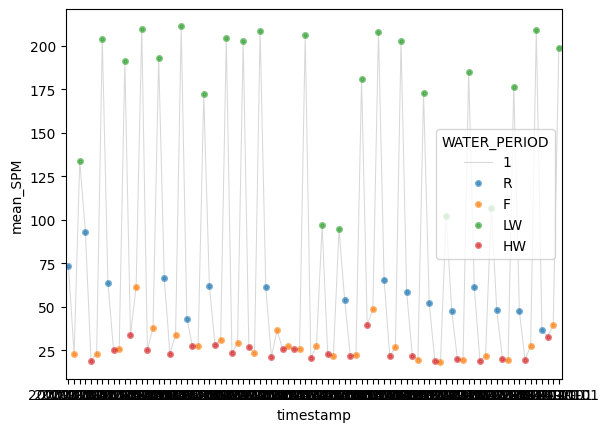

In [59]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'mean_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'mean_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

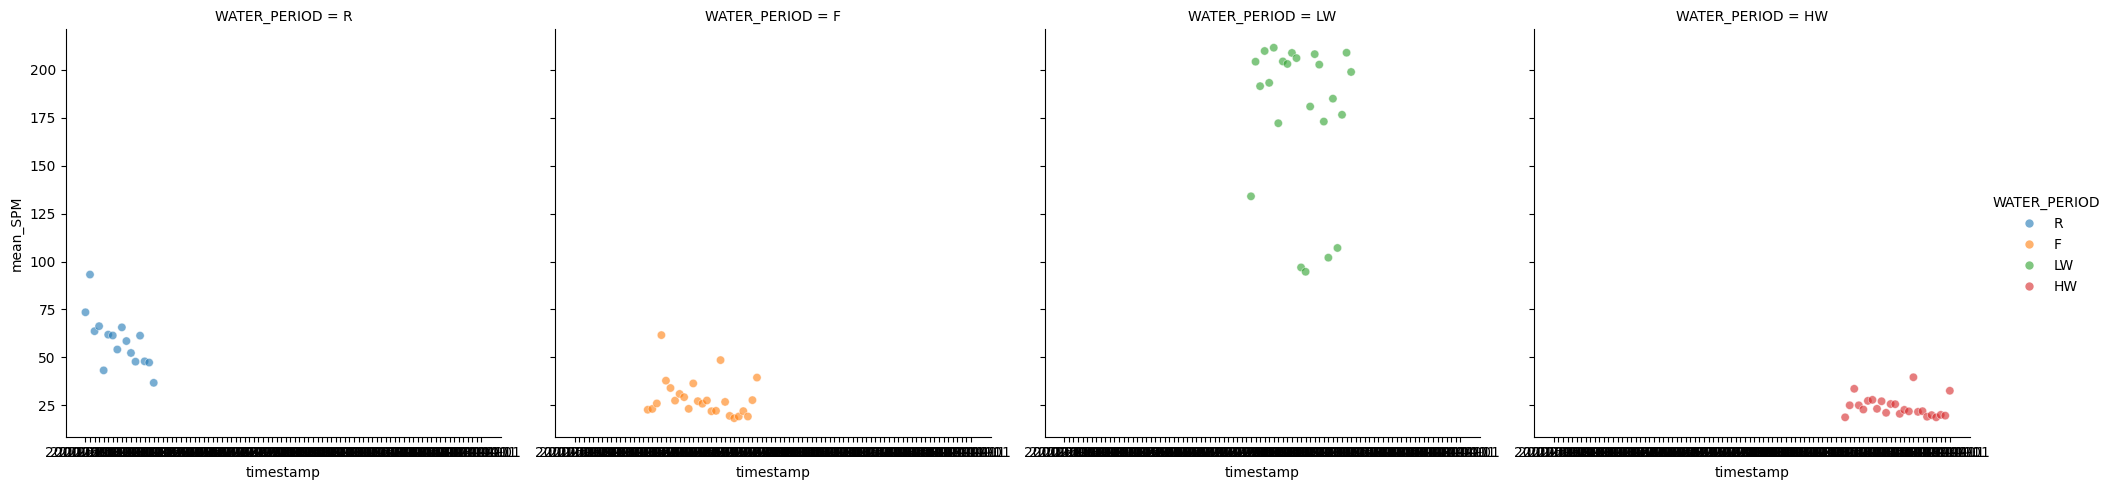

In [75]:
sns.relplot(data=dfArea, x ='timestamp',y= 'mean_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### max spm

<Axes: xlabel='timestamp', ylabel='max_SPM'>

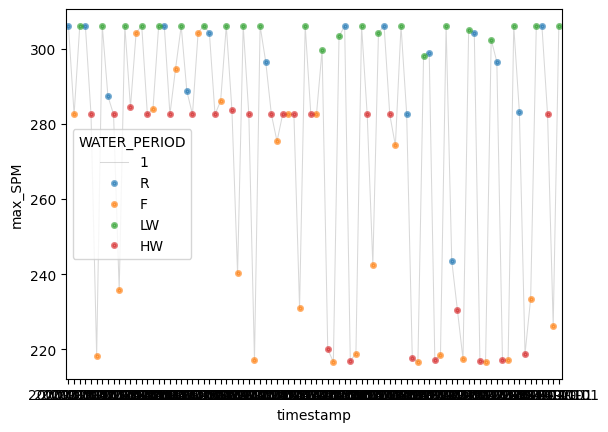

In [61]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'max_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'max_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

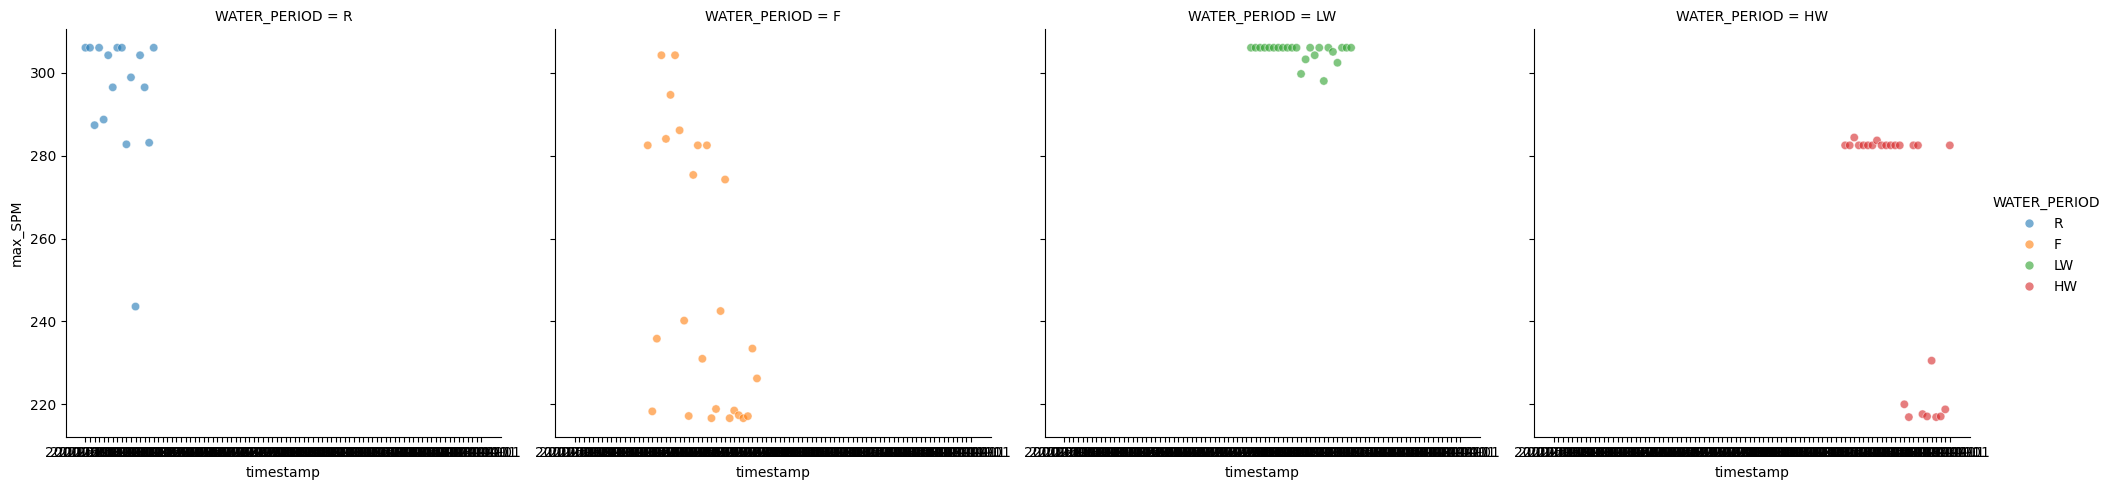

In [62]:
sns.relplot(data=dfArea, x ='timestamp',y= 'max_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### min spm

<Axes: xlabel='timestamp', ylabel='min_SPM'>

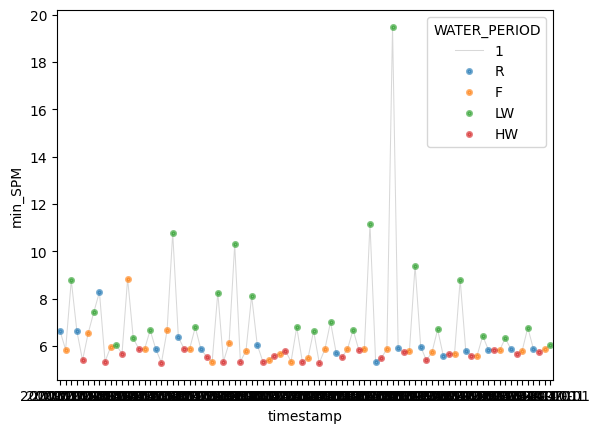

In [63]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'min_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'min_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

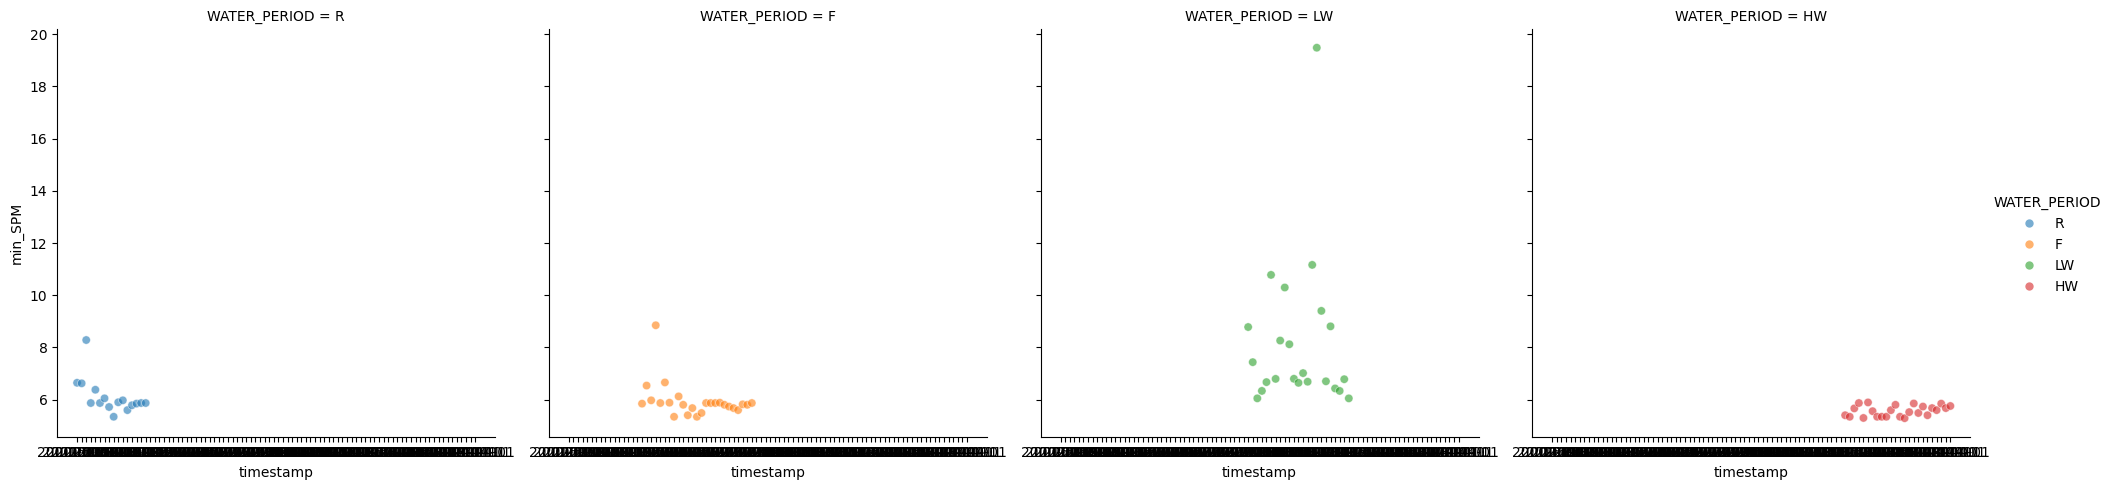

In [64]:
sns.relplot(data=dfArea, x ='timestamp',y= 'min_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

### std dev spm

<Axes: xlabel='timestamp', ylabel='stdDev_SPM'>

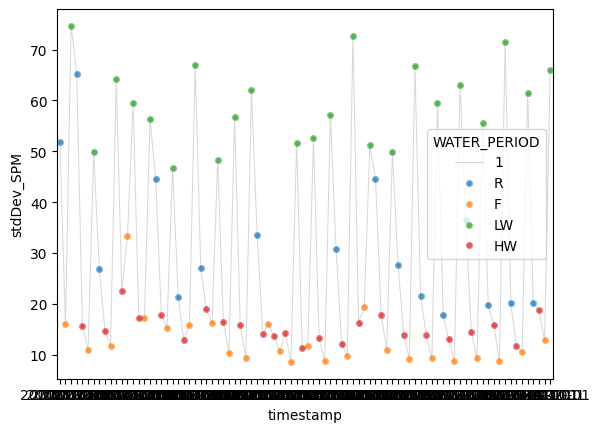

In [65]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

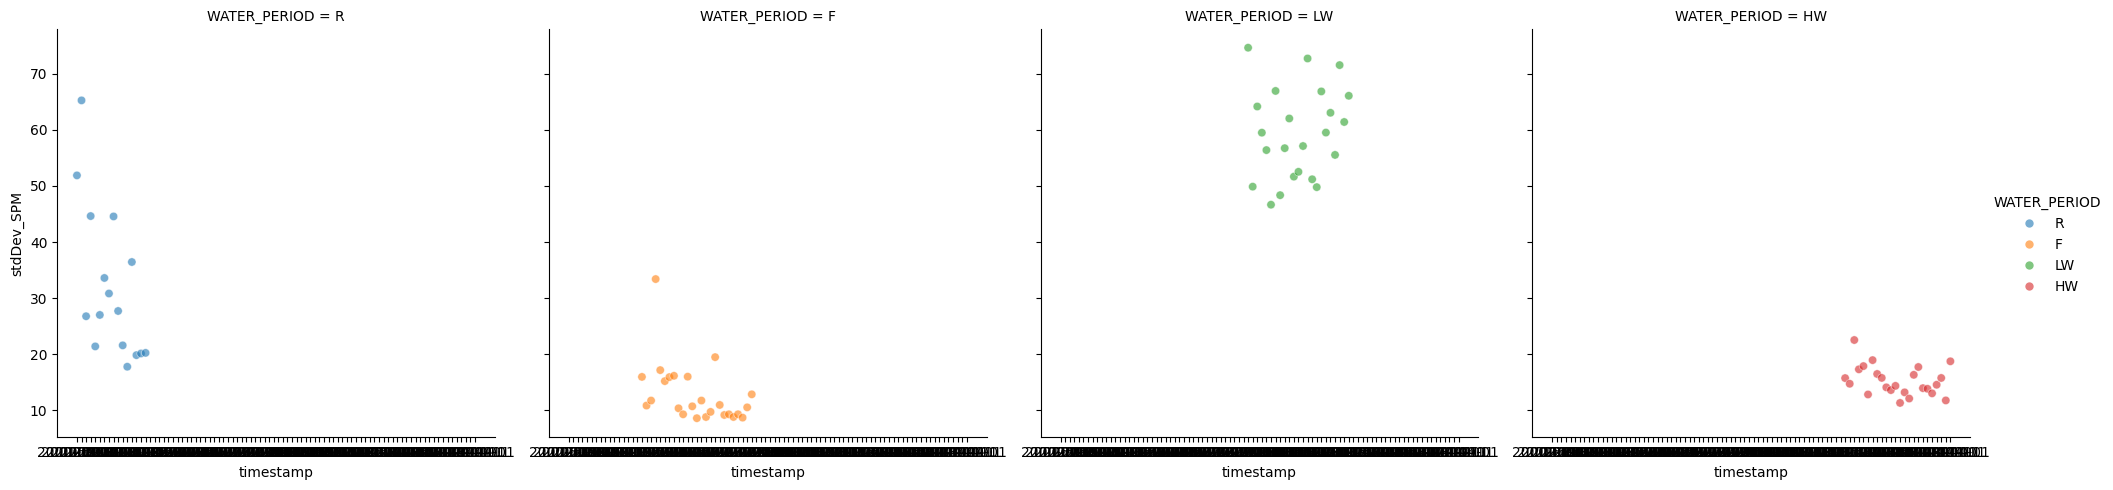

In [66]:
sns.relplot(data=dfArea, x ='timestamp',y= 'stdDev_SPM',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

# Data vizualization

In [67]:
dfArea.describe()

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,month_end,month_init,year
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,1212.133648,71.672432,275.593646,6.450083,29.088569,7.875000,5.875000,2012.375000
std,306.651157,67.829194,33.771140,1.855171,20.747571,3.194149,3.194149,7.463802
min,390.826379,18.263308,216.640869,5.287529,8.558269,3.000000,1.000000,2000.000000
25%,988.114911,23.139538,241.925220,5.672128,13.126836,6.000000,4.000000,2006.000000
50%,1325.063663,36.564975,282.928528,5.868872,17.799779,9.000000,7.000000,2013.000000
75%,1452.138795,95.231618,306.049042,6.628660,49.812609,12.000000,10.000000,2019.000000
max,1612.677713,211.574008,306.049042,19.483351,74.673074,12.000000,10.000000,2024.000000


<Axes: >

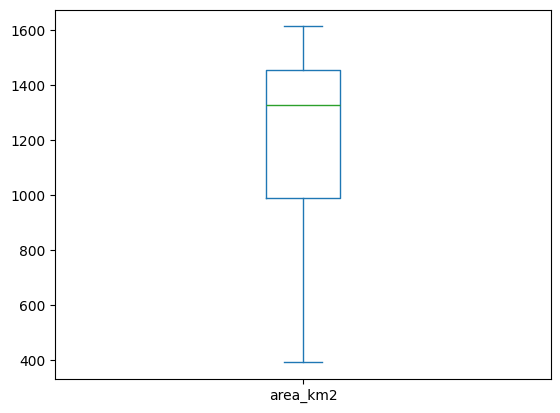

In [68]:
dfArea['area_km2'].plot.box()

<Axes: >

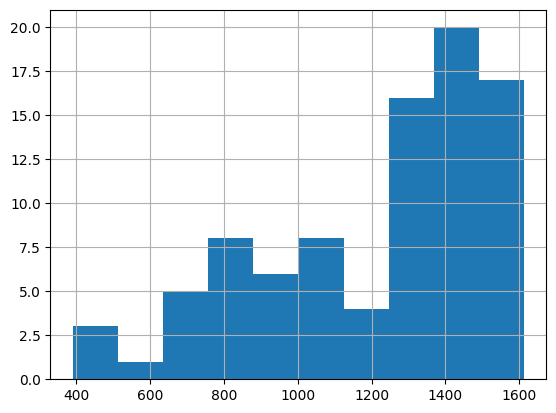

In [69]:
dfArea['area_km2'].hist()

<Axes: >

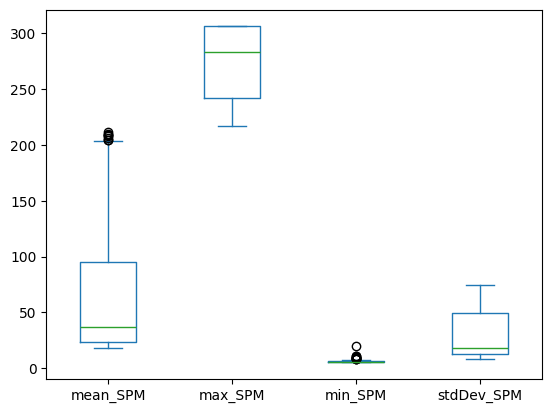

In [70]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].plot.box()

array([[<Axes: title={'center': 'mean_SPM'}>,
        <Axes: title={'center': 'max_SPM'}>],
       [<Axes: title={'center': 'min_SPM'}>,
        <Axes: title={'center': 'stdDev_SPM'}>]], dtype=object)

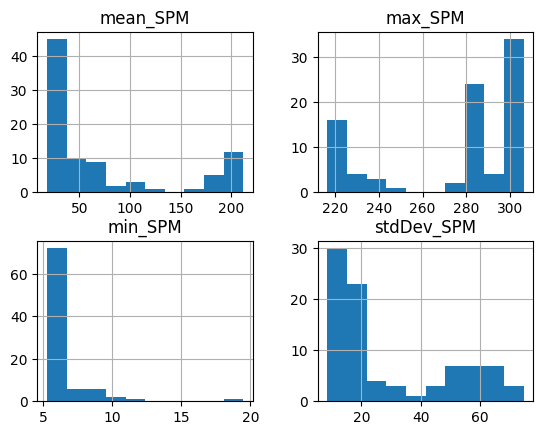

In [71]:
dfArea[['mean_SPM','max_SPM','min_SPM','stdDev_SPM']].hist()

##Export results

In [73]:
#export table results
dfArea.to_csv('/content/drive/MyDrive/CURUAI_PROCESS/area_SPM_time_series.csv')